# References

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../../fastai/old/') #fastai version 0.7
#sys.path.append('../../fastai/') #fastai version 1

from fastai.conv_learner import *
from fastai.dataset import *

import pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from pathlib import Path
from glob import glob
from matplotlib.patches import Rectangle
import png
from tqdm import tqdm_notebook as tqdm

In [2]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Global Variables

In [3]:
dp = Path('../../datasets/RSNA_PDC/')

DICOMS = dp/'stage_1_train_images'

PNGS = dp/'train_png'
PNGS.mkdir(exist_ok=True)

# Useful functions 

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def from_dicom_to_png(dicom_path, png_path):
    ds = pydicom.dcmread(dicom_path)
    shape = ds.pixel_array.shape
    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)
    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
    # Write the PNG file
    with open(png_path, 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)
        
        
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    parsed = collections.defaultdict(lambda:{'dicom': None,
                                        'png': None,     
                                        'label': None,
                                        'boxes': []})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = str(DICOMS/f'{pid}.dcm')
        parsed[pid]['png'] = str(PNGS/f'{pid}.png')
        parsed[pid]['label'] = row['Target']
        parsed[pid]['boxes'].append(hw_bb(row))

    return parsed

def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[-2:]-x[:2]), reverse=True)
    return [b[0]]

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, col='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=col, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(12,6), ax=ax)
    l = cats[ann['label']]
    for b in ann['boxes']:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], l, sz=16)
        
def draw_idx(im_a, ax=None):
    dcm_data = pydicom.read_file(im_a['dicom'])
    im = dcm_data.pixel_array
    draw_im(im, im_a, ax=ax)
    
def from_dicom_to_png(parsed):
    for k, v in parsed.items():
        dcm_data = pydicom.read_file(v['dicom'])
        im = dcm_data.pixel_array
        imageio.imwrite(v['png'], im)
        
class ObjDetDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds = ds 
        self.y2 = y2
    
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

# Data Exploration

## Paths 

In [292]:
list(dp.iterdir())

[PosixPath('../../datasets/RSNA_PDC/image_bbox_full.csv'),
 PosixPath('../../datasets/RSNA_PDC/models'),
 PosixPath('../../datasets/RSNA_PDC/image_bbox_distinct_full.csv'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_test_images'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_detailed_class_info.csv'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_sample_submission.csv'),
 PosixPath('../../datasets/RSNA_PDC/tmp'),
 PosixPath('../../datasets/RSNA_PDC/GCP Credits Request Link - RSNA.txt'),
 PosixPath('../../datasets/RSNA_PDC/.ipynb_checkpoints'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_train_images'),
 PosixPath('../../datasets/RSNA_PDC/train_png'),
 PosixPath('../../datasets/RSNA_PDC/stage_1_train_labels.csv')]

In [293]:
s1_dci, s1_ssub, s1_tls, images = ['stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_train_labels.csv', 'stage_1_train_images']

## Detailed class info csv file

In [ ]:
dci_df = pd.read_csv(dp/s1_dci)
print(dci_df.shape[0])
dci_df[:5]

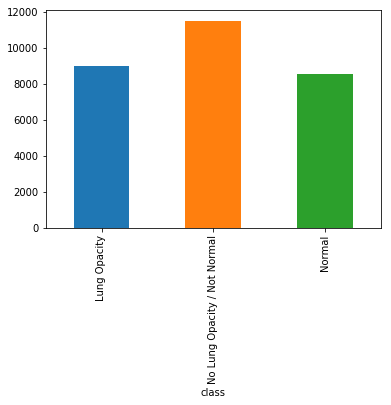

In [142]:
dci_df.groupby('class').size().plot.bar()

## Bounding boxes csv file

In [143]:
bbox_df = pd.read_csv(dp/s1_tls)
bbox_df[:5]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


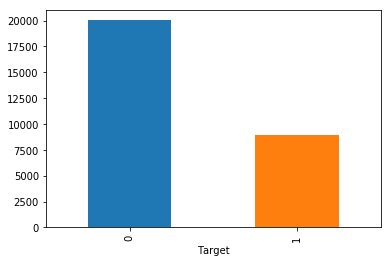

In [144]:
bbox_df.groupby('Target').size().plot.bar()

## Combine boxes and labels 

In [145]:
comb_bbox_df = pd.concat([bbox_df, 
                        dci_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df[:5]

28989 combined cases


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


## Distribution of boxes per patient

In [146]:
box_df = comb_bbox_df.groupby('patientId')['x'].count().reset_index(name='boxes')
box_df
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,0,20025
1,1,2481
2,2,3062
3,3,105
4,4,11


## Relation of class and target

In [147]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


##  Images

### Image ids 

In [148]:
image_df = pd.DataFrame({'path' : glob(os.path.join(dp/images, '*.dcm'))})
image_df['patientId'] = image_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
image_df

,path,patientId
0,../../datasets/RSNA_PDC/stage_1_train_images/c...,c574be57-1288-4b87-940f-5c45be1fddce
1,../../datasets/RSNA_PDC/stage_1_train_images/8...,8570eacc-7d96-40b8-9be9-11a7b56db4c7
2,../../datasets/RSNA_PDC/stage_1_train_images/8...,863a923a-3906-42d3-92db-76c900091fce
3,../../datasets/RSNA_PDC/stage_1_train_images/b...,bf7bc9a6-d454-4edd-8752-9273448a3b10
4,../../datasets/RSNA_PDC/stage_1_train_images/4...,49c413cc-e806-4bc4-b744-1987261282c1
5,../../datasets/RSNA_PDC/stage_1_train_images/c...,c3fd576c-20f1-4d10-a96f-8cea38100bb3
6,../../datasets/RSNA_PDC/stage_1_train_images/7...,7cec580b-d147-4f31-8e2b-41ffe8c940c7
7,../../datasets/RSNA_PDC/stage_1_train_images/7...,7464e292-ecd7-4806-957d-dbab928c9579
8,../../datasets/RSNA_PDC/stage_1_train_images/2...,2eb0a283-bb6d-48ef-9c11-a0924f32e67b
9,../../datasets/RSNA_PDC/stage_1_train_images/7...,7ce31482-fdad-4830-96a8-1a6ac96c544d


In [149]:
print(image_df.shape[0], 'images found')

25684 images found


In [150]:
img_pat_ids = set(image_df['patientId'])
box_pat_ids = set(comb_box_df['patientId'])
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

### DICOM headers and full final dataframe with all information about an image

In [151]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)

,BodyPartExamined,ViewPosition,PatientSex
count,25684,25684,25684
unique,1,2,2
top,CHEST,PA,M
freq,25684,13979,14593


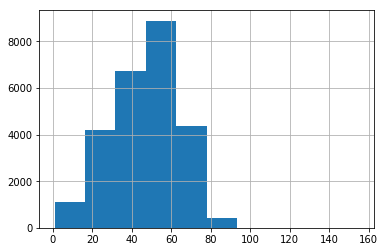

In [152]:
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [153]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df

28989 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M


### Create Sample Data Set

In [154]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,b3cbf083-1967-4d4a-a0a5-a1df34eecae2,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/b...,40,CHEST,PA,M
1,481ff753-4106-405c-962e-a3f1c1e3bc37,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/4...,20,CHEST,PA,F
2,a9a0308c-67af-4872-89f6-e9ecb5390ada,156.0,146.0,295.0,556.0,1,Lung Opacity,1,../../datasets/RSNA_PDC/stage_1_train_images/a...,55,CHEST,AP,M
3,b406e391-9f28-4f26-a71f-285d5e3f488c,285.0,482.0,224.0,353.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/b...,58,CHEST,AP,F
4,b406e391-9f28-4f26-a71f-285d5e3f488c,649.0,455.0,202.0,391.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/b...,58,CHEST,AP,F
5,aea56cac-4a31-44b4-b007-1385775d939d,598.0,627.0,149.0,292.0,1,Lung Opacity,3,../../datasets/RSNA_PDC/stage_1_train_images/a...,63,CHEST,AP,F
6,aea56cac-4a31-44b4-b007-1385775d939d,567.0,254.0,125.0,239.0,1,Lung Opacity,3,../../datasets/RSNA_PDC/stage_1_train_images/a...,63,CHEST,AP,F
7,aea56cac-4a31-44b4-b007-1385775d939d,107.0,558.0,231.0,232.0,1,Lung Opacity,3,../../datasets/RSNA_PDC/stage_1_train_images/a...,63,CHEST,AP,F
8,7d674c82-5501-4730-92c5-d241fd6911e7,358.0,320.0,159.0,186.0,1,Lung Opacity,4,../../datasets/RSNA_PDC/stage_1_train_images/7...,52,CHEST,AP,F
9,7d674c82-5501-4730-92c5-d241fd6911e7,283.0,528.0,197.0,314.0,1,Lung Opacity,4,../../datasets/RSNA_PDC/stage_1_train_images/7...,52,CHEST,AP,F


### Show the position and bounding box

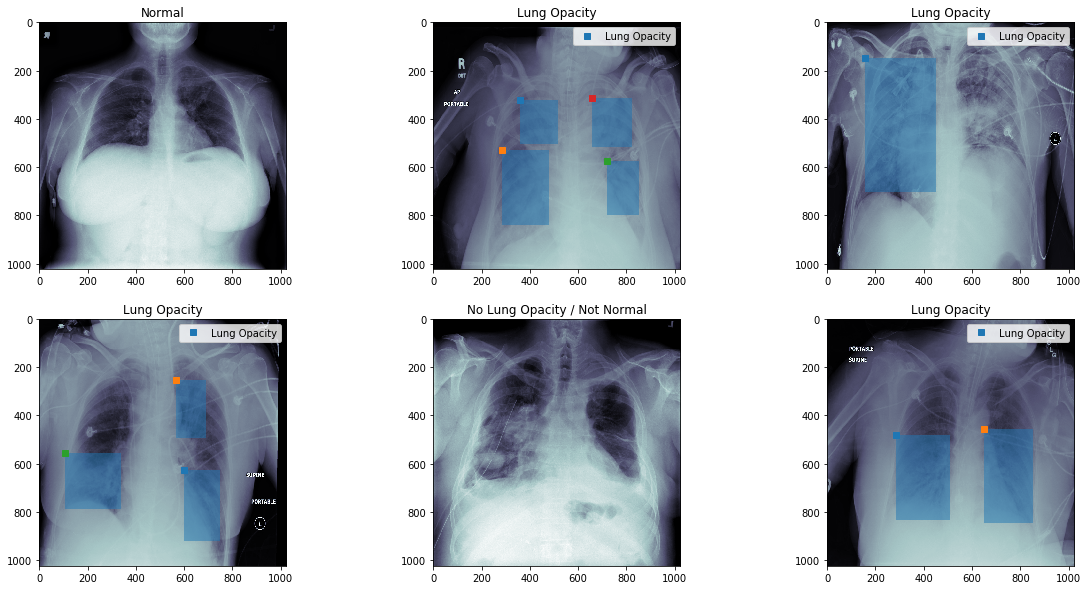

In [157]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

### Bounding Box Distribution 

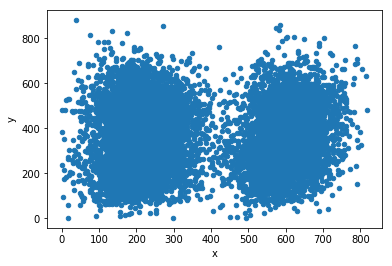

In [149]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

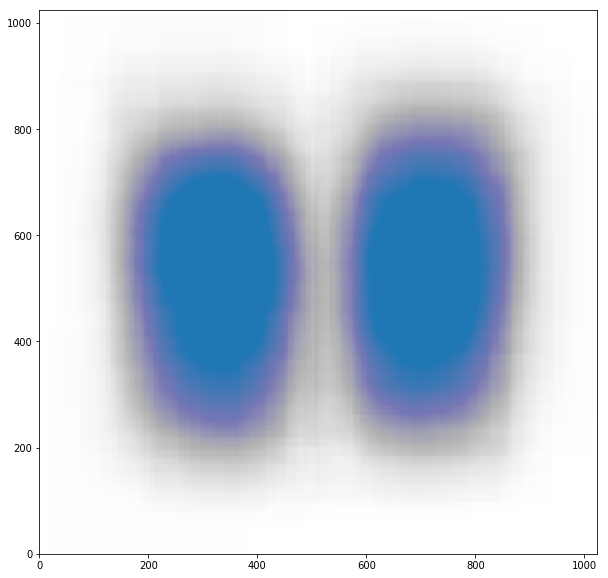

In [150]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

### Show the boxes as segmentation

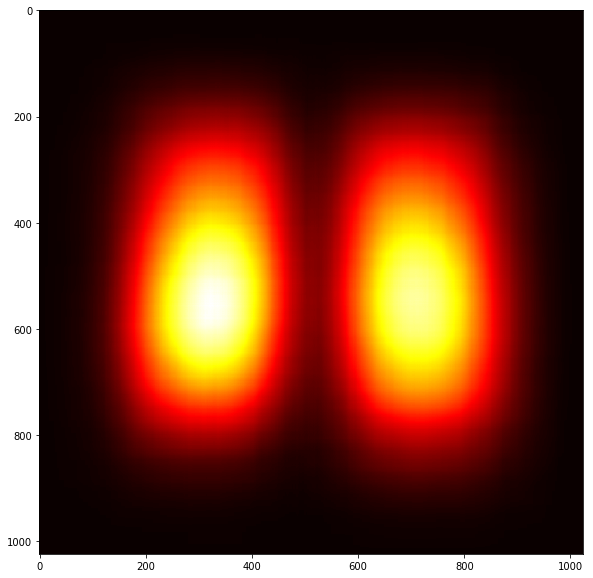

In [151]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

### Overlay the Probability on a few images

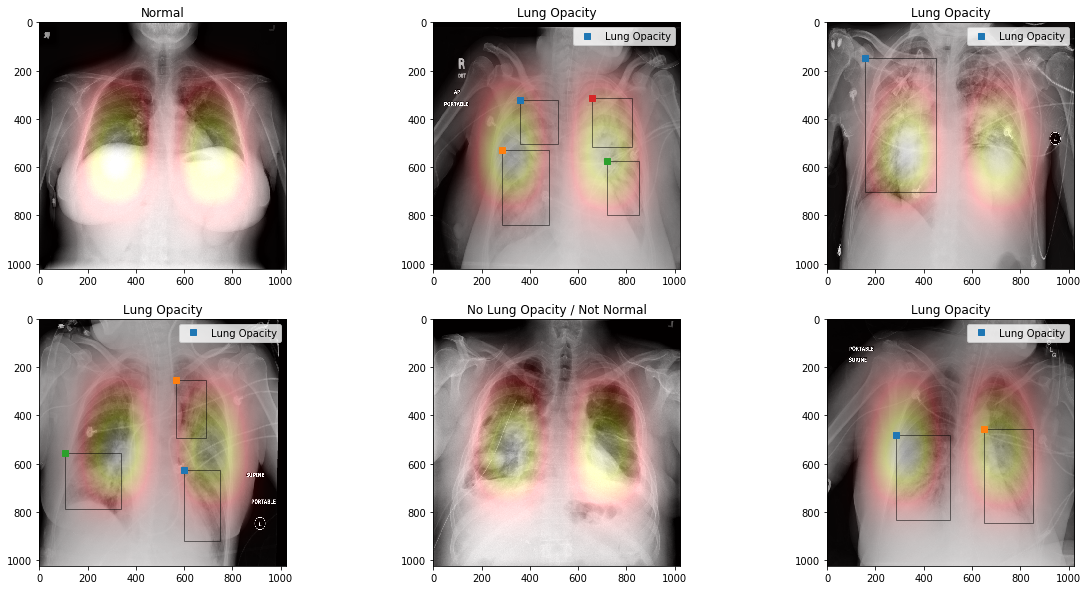

In [152]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
#fig.savefig('overview.png', figdpi = 600)

### Save the preprocessed results

In [26]:
image_bbox_df.to_csv(dp/'image_bbox_full.csv', index=False)

# Classifier opacity, no opacity

## Add new coloumn: opacity/no opacity

In [23]:
image_bbox_df = pd.read_csv(dp/'image_bbox_full.csv')
image_bbox_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,opacity/no opacity,png_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F,no opacity,../../datasets/RSNA_PDC/train_png/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F,no opacity,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M,no opacity,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M,no opacity,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M,no opacity,../../datasets/RSNA_PDC/train_png/00569f44-917...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M,no opacity,../../datasets/RSNA_PDC/train_png/006cec2e-6ce...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...


In [24]:
targets = image_bbox_df['Target']
targets

0        0
1        0
2        0
3        0
4        1
5        1
6        0
7        0
8        1
9        1
10       0
11       0
12       0
13       0
14       1
15       1
16       1
17       1
18       0
19       1
20       1
21       0
22       1
23       0
24       1
25       1
26       0
27       1
28       1
29       0
        ..
28959    0
28960    0
28961    0
28962    0
28963    0
28964    0
28965    0
28966    1
28967    1
28968    0
28969    0
28970    0
28971    0
28972    0
28973    0
28974    0
28975    0
28976    0
28977    0
28978    0
28979    1
28980    0
28981    0
28982    0
28983    1
28984    1
28985    0
28986    0
28987    0
28988    0
Name: Target, Length: 28989, dtype: int64

In [25]:
classes = []
for n, t in tqdm(enumerate(targets), total=len(targets)):
    if t == 0:
        classes.append('no_opacity')
    else:
        classes.append('opacity')

In [26]:
classes

['no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'opacity',
 'opacity',
 'no_opacity',
 'opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_opacity',
 'no_op

In [27]:
image_bbox_df['opacity/no opacity'] = classes

In [28]:
image_bbox_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,opacity/no opacity,png_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00569f44-917...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/006cec2e-6ce...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...


## Convert .dcm to .png

### Add coloumn with paths for .png images

In [29]:
image_bbox_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,opacity/no opacity,png_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00569f44-917...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/006cec2e-6ce...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...


In [30]:
patientIds = image_bbox_df['patientId']
png_paths = []
for i in patientIds:
    n = i+'.png'
    png_paths.append(PNGS/n)

image_bbox_df['png_path'] = png_paths
image_bbox_df

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,opacity/no opacity,png_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00569f44-917...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/006cec2e-6ce...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...


### Create a distinct list of patient ids

In [31]:
image_bbox_df_distinct = image_bbox_df.drop_duplicates(subset='path', keep='first')
image_bbox_df_distinct

,patientId,x,y,width,height,Target,class,boxes,path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,opacity/no opacity,png_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,51,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,48,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,19,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,28,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,32,CHEST,AP,F,opacity,../../datasets/RSNA_PDC/train_png/00436515-870...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,54,CHEST,AP,M,no_opacity,../../datasets/RSNA_PDC/train_png/00569f44-917...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,78,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/006cec2e-6ce...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2,../../datasets/RSNA_PDC/stage_1_train_images/0...,75,CHEST,PA,M,opacity,../../datasets/RSNA_PDC/train_png/00704310-78a...
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,59,CHEST,PA,F,no_opacity,../../datasets/RSNA_PDC/train_png/008c19e8-a82...
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0,Normal,0,../../datasets/RSNA_PDC/stage_1_train_images/0...,63,CHEST,PA,M,no_opacity,../../datasets/RSNA_PDC/train_png/009482dc-3db...


### Save/read dfs as/from csv

In [32]:
image_bbox_full_csv_name = 'image_bbox_full.csv'
image_bbox_distinct_full_csv_name = 'image_bbox_distinct_full.csv'

In [33]:
image_bbox_df.to_csv(dp/image_bbox_full_csv_name, index=False)
image_bbox_df_distinct.to_csv(dp/image_bbox_distinct_full_csv_name, index=False)

In [34]:
image_bbox_df = pd.read_csv(dp/image_bbox_full_csv_name)
image_bbox_df_distinct = pd.read_csv(dp/image_bbox_distinct_full_csv_name)

### Converting

In [ ]:
for index, row in tqdm(image_bbox_df_distinct.iterrows(), total=image_bbox_df_distinct.shape[0]):
    if not os.path.isfile(row['png_path']):
        from_dicom_to_png(row['path'], row['png_path'])

len(list(PNGS.iterdir()))

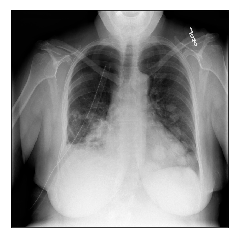

In [38]:
img = open_image(image_bbox_df_distinct['png_path'][0])
show_img(img)

## Build and train model

In [210]:
df = pd.DataFrame({'fn': image_bbox_df_distinct['patientId']+'.png', 'cat' : image_bbox_df['opacity/no opacity']})
df = df.dropna()
df = df.reset_index()
df = df.drop(df.columns[[0]], axis=1)
df

,fn,cat
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,no_opacity
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,no_opacity
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,no_opacity
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,no_opacity
4,00436515-870c-4b36-a041-de91049b9ab4.png,opacity
5,00569f44-917d-4c86-a842-81832af98c30.png,opacity
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970.png,no_opacity
7,00704310-78a8-4b38-8475-49f4573b2dbb.png,no_opacity
8,008c19e8-a820-403a-930a-bc74a4053664.png,opacity
9,009482dc-3db5-48d4-8580-5c89c4f01334.png,opacity


In [211]:
(dp/'tmp').mkdir(exist_ok=True)
CSV = dp/'tmp/class.csv'
df.to_csv(CSV, index=False)

In [80]:
f_model = resnet34
sz=224
bs=64

In [81]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms, bs=bs)

In [82]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [83]:
learn.get_activations

<bound method ConvLearner.get_activations of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [84]:
lrf=learn.lr_find(1e-5,100)

 66%|██████▋   | 214/322 [02:42<01:21,  1.32it/s, loss=3.15] 

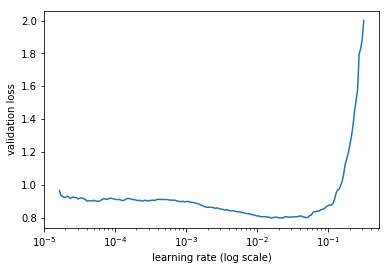

In [85]:
learn.sched.plot()

In [86]:
lr = 2e-3

In [87]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.644721   0.64159    0.672508  


[0.6415904544966986, 0.6725077881619937]

In [88]:
lrs = np.array([lr/1000,lr/100,lr])

In [89]:
learn.freeze_to(-2)

 80%|███████▉  | 257/322 [03:21<00:51,  1.27it/s, loss=2.17] 

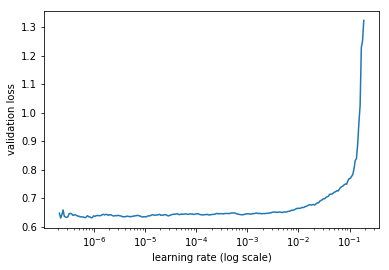

In [91]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

In [92]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.641721   0.6359     0.672702  


[0.6358996265773833, 0.672702492211838]

In [95]:
learn.unfreeze()

In [96]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.634489   0.636604   0.672702  
    1      0.626927   0.634697   0.672702                    


[0.6346970982269334, 0.672702492211838]

In [97]:
learn.save('opacity-no_opacity-classifier')

In [98]:
learn.load('opacity-no_opacity-classifier')

In [112]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [132]:
y

tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')

In [134]:
y_np = to_np(y)
y_np

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1])

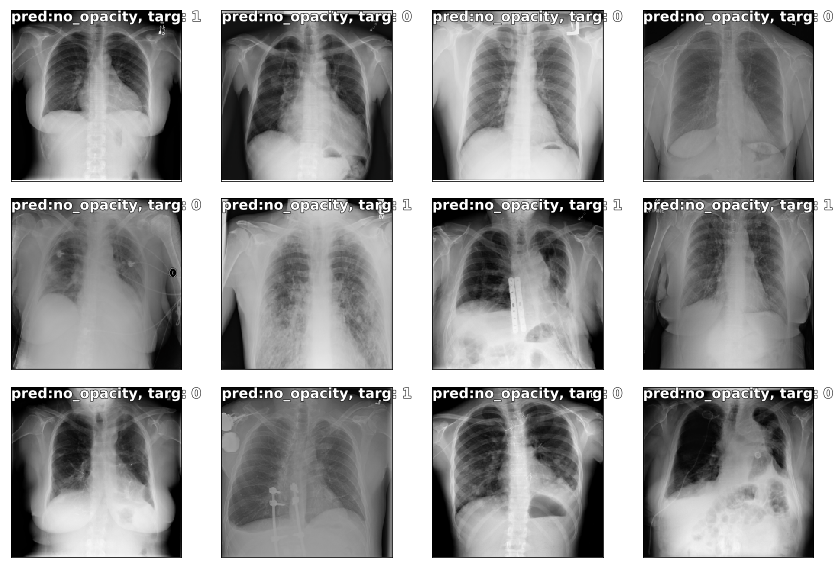

In [137]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), f'pred:{b}, targ: {y_np[i]}')
plt.tight_layout()

# Largest pneumonia focus classifier

## dataframe and csv preparation

In [6]:
labs = pd.read_csv(dp/'stage_1_train_labels.csv')
labs.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
labs.x.fillna(0, inplace=True)
labs.y.fillna(0, inplace=True)
labs.width.fillna(1023, inplace=True)
labs.height.fillna(1023, inplace=True)

labs.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,1023.0,1023.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,1023.0,1023.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,1023.0,1023.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,1023.0,1023.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
parsed = parse_data(labs)

parsed_lrg = {a: {'dicom': b['dicom'],
                  'png': b['png'],
                  'label': b['label'],
                  'boxes': get_lrg(b['boxes'])} for a, b in parsed.items()}

In [9]:
cats = {0: 'normal', 1: 'pneumonia'}

In [10]:
patient = '3b081d12-6804-4a33-85cd-712a886e4e01'
parsed[patient]

{'dicom': '../../datasets/RSNA_PDC/stage_1_train_images/3b081d12-6804-4a33-85cd-712a886e4e01.dcm',
 'png': '../../datasets/RSNA_PDC/train_png/3b081d12-6804-4a33-85cd-712a886e4e01.png',
 'label': 1,
 'boxes': [array([211., 590., 478., 768.]), array([241., 227., 737., 445.])]}

In [11]:
parsed_lrg[patient]

{'dicom': '../../datasets/RSNA_PDC/stage_1_train_images/3b081d12-6804-4a33-85cd-712a886e4e01.dcm',
 'png': '../../datasets/RSNA_PDC/train_png/3b081d12-6804-4a33-85cd-712a886e4e01.png',
 'label': 1,
 'boxes': [array([241., 227., 737., 445.])]}

In [12]:
bb = parsed_lrg[patient]['boxes'][0]
bb_transformed = bb_hw(bb)
bb_original = labs.loc[labs.patientId == patient,:].iloc[1]

print(f'Top-Left-Bottom-Right BB: {bb}')
print(f'Transformed Top-Left-WH: {bb_transformed}')
print(f'Original Top-Left-WH: [{bb_original.x} {bb_original.y} {bb_original.width} {bb_original.height}]')

Top-Left-Bottom-Right BB: [241. 227. 737. 445.]
Transformed Top-Left-WH: [227. 241. 218. 496.]
Original Top-Left-WH: [227.0 241.0 218.0 496.0]


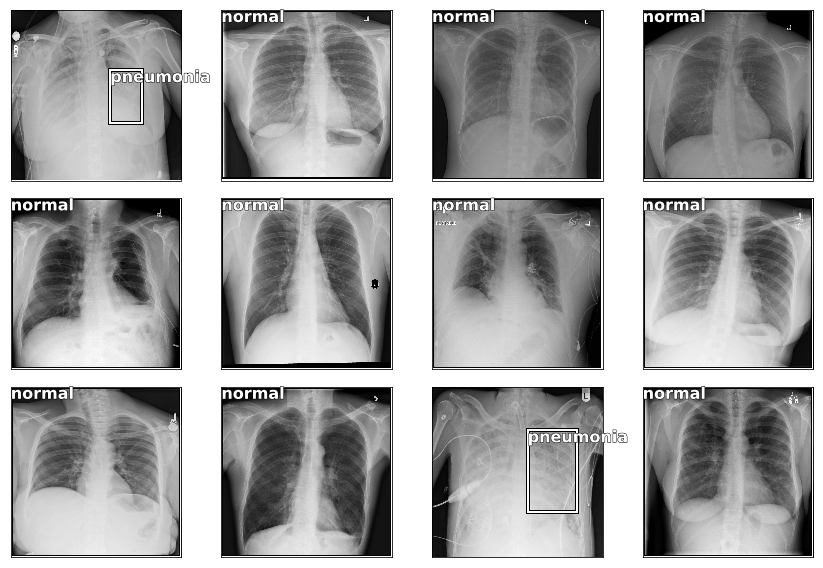

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    patient = labs.patientId.sample().values[0]
    draw_idx(parsed_lrg[patient], ax=ax)

plt.tight_layout()

In [27]:
(dp/'tmp').mkdir(exist_ok=True)

CSV = dp/'tmp/class.csv'
BB_CSV = dp/'tmp/bb.csv'

In [15]:
df_lrg = pd.DataFrame({'fn': [parsed_lrg[o]['png'] for o in parsed_lrg],
                   'cat': [parsed_lrg[o]['label'] for o in parsed_lrg],
                   'bbox': [' '.join(str(p) for p in parsed_lrg[o]['boxes'][0]) for o in parsed_lrg]})

In [16]:
df_lrg.head()

,fn,cat,bbox
0,../../datasets/RSNA_PDC/train_png/0004cfab-14f...,0,0.0 0.0 1023.0 1023.0
1,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...,0,0.0 0.0 1023.0 1023.0
2,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...,0,0.0 0.0 1023.0 1023.0
3,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...,0,0.0 0.0 1023.0 1023.0
4,../../datasets/RSNA_PDC/train_png/00436515-870...,1,152.0 562.0 605.0 818.0


In [17]:
df_lrg.cat.sum()/df_lrg.shape[0]

0.22033172403052484

In [18]:
li = [str(el) for el in list((PNGS).iterdir())]
len(li)

25684

In [19]:
dfs = df_lrg.loc[df_lrg.fn.isin(li),:]
dfs.shape

(25684, 3)

In [20]:
dfs.head()

,fn,cat,bbox
0,../../datasets/RSNA_PDC/train_png/0004cfab-14f...,0,0.0 0.0 1023.0 1023.0
1,../../datasets/RSNA_PDC/train_png/00313ee0-9ea...,0,0.0 0.0 1023.0 1023.0
2,../../datasets/RSNA_PDC/train_png/00322d4d-1c2...,0,0.0 0.0 1023.0 1023.0
3,../../datasets/RSNA_PDC/train_png/003d8fa0-6bf...,0,0.0 0.0 1023.0 1023.0
4,../../datasets/RSNA_PDC/train_png/00436515-870...,1,152.0 562.0 605.0 818.0


In [21]:
filePaths = dfs['fn']
fns = []
for f in filePaths:
    fns.append(os.path.basename(f))
    
dfs['fn'] = fns


In [22]:
dfs.head()

,fn,cat,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0,0.0 0.0 1023.0 1023.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0,0.0 0.0 1023.0 1023.0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,0,0.0 0.0 1023.0 1023.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,0,0.0 0.0 1023.0 1023.0
4,00436515-870c-4b36-a041-de91049b9ab4.png,1,152.0 562.0 605.0 818.0


In [23]:
dfs.cat.sum()/dfs.shape[0]

0.22033172403052484

In [24]:
dfs[['fn', 'bbox']].to_csv(BB_CSV, index=False)

In [25]:
dfs[['fn', 'bbox']].head()

,fn,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0.0 0.0 1023.0 1023.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0.0 0.0 1023.0 1023.0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,0.0 0.0 1023.0 1023.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,0.0 0.0 1023.0 1023.0
4,00436515-870c-4b36-a041-de91049b9ab4.png,152.0 562.0 605.0 818.0


## Largest opacity detection modeling pipeline

### Figuring out input dimension of custom head to stack on top of CNN

In [28]:
cl_df = pd.read_csv(CSV)
cl_df.head()

,fn,cat
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,no_opacity
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,no_opacity
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,no_opacity
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,no_opacity
4,00436515-870c-4b36-a041-de91049b9ab4.png,opacity


In [159]:
f_model = resnet34
sz=512
bs=8

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 512, 512]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_sha

The output dimension of the last Conv Block (BasicBlock-122) is [-1, 512, 16, 16].
We will make use of the very handy head concept within the fast.ai library 
which allows to truncate the pre-trained network to its last conv layer and stack a custom model on top.
The input shape of the custom head will be 512 * 16 * 16 = 131072

In [30]:
input_to_top_model = 512 * 16 * 16

### Combinig boxes and classes in one dataset

In [31]:
dfs.head()

,fn,cat,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0,0.0 0.0 1023.0 1023.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0,0.0 0.0 1023.0 1023.0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,0,0.0 0.0 1023.0 1023.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,0,0.0 0.0 1023.0 1023.0
4,00436515-870c-4b36-a041-de91049b9ab4.png,1,152.0 562.0 605.0 818.0


In [32]:
f_model = resnet34
sz=512
bs=8

val_idxs = get_cv_idxs(len(dfs))

In [33]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [34]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [35]:
md_box = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)

In [36]:
md_class = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms_from_model(f_model, sz), bs=bs)

In [37]:
trn_ds = ObjDetDataset(md_box.trn_ds, md_class.trn_y)
val_ds = ObjDetDataset(md_box.val_ds, md_class.val_y)

In [38]:
trn_ds[0][1]

(array([  0.,   0., 510., 510.], dtype=float32), 0)

In [40]:
md_box.trn_dl.dataset = trn_ds
md_box.val_dl.dataset = val_ds

In [55]:
x,y=next(iter(md_box.val_dl))

In [56]:
idx=3
ima=md_box.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])) 
b

array([  0.,   0., 510., 510.], dtype=float32)

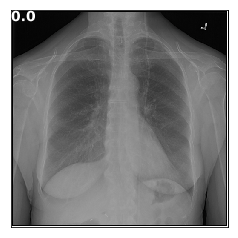

In [57]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md_box.classes[y[1][idx]])

### Check augmented data

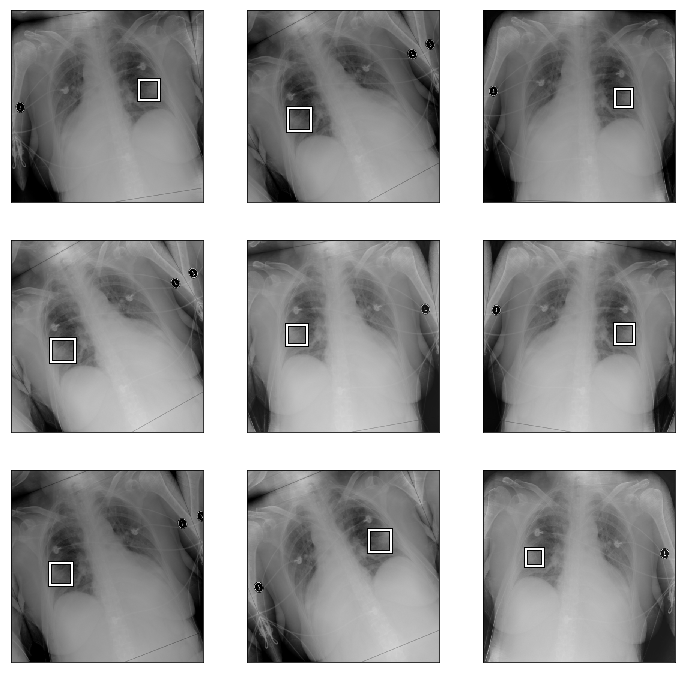

In [59]:
idx = 4
fig,axes = plt.subplots(3,3, figsize=(12,12))
for i,ax in enumerate(axes.flat):
    x, y= next(iter(md_box.aug_dl))
    ima = md_box.val_ds.ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    draw_rect(ax, b)

### Custom head

In [62]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(input_to_top_model,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md_box, models)
learn.opt_fn = optim.Adam

### How much do we need to multiply the cross_entropy to make it comparable to the f1_loss?

In [67]:
ratios = []

for i in range(200):
    x, y = next(iter(md_box.trn_dl))
    t = learn.model(V(x))
    
    bb_t,c_t = y
    bb_i,c_i = t[:, :4], t[:, 4:]
    bb_i = torch.sigmoid(bb_i)*sz
    
    reg = F.l1_loss(bb_i, V(bb_t)).data.cpu().numpy()
    clas = F.cross_entropy(c_i, V(c_t)).data.cpu().numpy()
    
    print(reg/clas)
    ratios.append(reg/clas)

383.6425
263.59686
256.61432
309.1202
337.50516
231.26935
363.4966
309.65244
287.57138
393.94104
336.09088
258.1885
286.20944
293.542
316.44992
260.22778
273.29343
253.03798
272.90707
265.71243
250.73439
315.12827
344.45114
338.23346
337.64688
191.29994
453.81656
344.3561
229.62695
348.04944
389.22873
338.84195
390.53033
312.70715
252.20918
269.32635
268.951
373.62964
355.87604
252.13269
282.8481
203.83536
497.93546
376.80627
389.15967
218.73337
315.1897
249.79398
340.32962
256.60962
259.74612
243.31148
290.50195
332.14066
275.44113
333.5672
331.23923
288.91293
379.84958
280.6668
226.71216
504.34586
370.6059
238.88966
249.37216
236.77295
476.3581
399.64185
368.0715
368.69916
403.38358
261.60223
245.9587
296.85553
377.65088
284.60464
356.22098
329.25266
255.09044
209.78825
286.99652
279.03235
286.23965
255.61281
221.41751
292.28796
214.10938
411.48492
370.3509
209.77597
248.57762
304.1071
336.41772
277.2026
327.59747
368.5397
288.3634
448.01657
261.14703
299.9896
334.72015
268.68683
283

In [70]:
np.mean(ratios)

311.67154

In [71]:
np.median(ratios)

292.9333

In [72]:
scaler = int(np.mean(ratios))

In [73]:
scaler

311

### Loss function

In [77]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = torch.sigmoid(bb_i)*sz
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*scaler

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = torch.sigmoid(bb_i)*sz
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

### Train

 66%|██████▋   | 1704/2569 [05:15<02:39,  5.41it/s, loss=883]

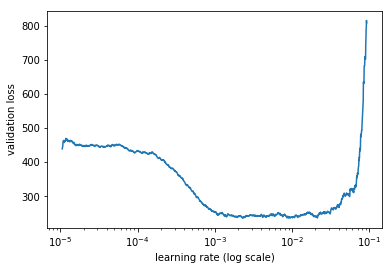

In [78]:
learn.lr_find()
learn.sched.plot()

In [82]:
lr = 2e-4

In [83]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1          
    0      242.562142 238.02222  0.672508   39.317627 
    1      229.042695 236.21927  0.672702   39.1767          
    2      228.691533 236.143309 0.672702   39.066894        


[236.14330894256307, 0.672702492211838, 39.06689417408634]

In [84]:
lrs = np.array([lr/100, lr/10, lr])

 73%|███████▎  | 1887/2569 [05:46<02:05,  5.44it/s, loss=783]

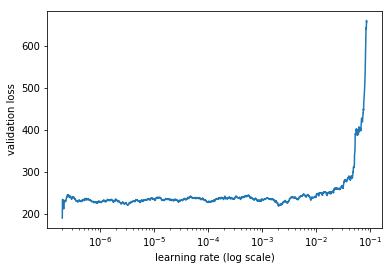

In [85]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [86]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1          
    0      233.38178  235.482904 0.672702   38.498128 
    1      230.81434  236.103748 0.672702   39.000584        
    2      234.49172  236.675971 0.672702   38.645338        
    3      227.352491 236.659097 0.672702   39.500855        
    4      234.967877 236.701601 0.672702   38.849898        


[236.70160053526502, 0.672702492211838, 38.84989792897694]

In [87]:
learn.unfreeze()

In [88]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

  9%|▉         | 227/2569 [00:55<09:30,  4.10it/s, loss=235]

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.sched.plot_lr()

### Looking at the results

In [ ]:
y = learn.predict()

In [ ]:
idx = np.random.randint(low=0, high=(len(md_box.val_ds)-1), size=16)

In [ ]:
names = md_box.val_ds.ds.fnames[idx]
true_label = [cats[i] for i in md_box.val_ds.y2[idx]]
true_box = md_box.val_ds.ds.y[idx]

pred_label = [cats[i] for i in np.argmax(y[idx, 4:], axis=1)]
pred_box = (expit(y[idx, :4])*1024).astype(int)

In [ ]:
fig,axes = plt.subplots(4,4, figsize=(16,16))

for i,ax in enumerate(axes.flat):
    im = imageio.imread(names[i])
    ax = show_img(im, ax=ax)
    draw_rect(ax, true_box[i])
    draw_rect(ax, pred_box[i], col='blue')
    draw_text(ax, true_box[i][:2], true_label[i])
    draw_text(ax, pred_box[i][:2]+np.array([0,60]), pred_label[i], col='blue')
    
fig.suptitle('16 Random Validation Images (WHITE = Actual; BLUE = Predicted)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Bbox per cell

## Set up data

In [5]:
CLAS_CSV = dp/'tmp/class.csv'
MBB_CSV = dp/'tmp/mbb.csv'

f_model=resnet34
sz=512
bs=16

In [6]:
labs2 = pd.read_csv(dp/'stage_1_train_labels.csv')
labs2.head(20)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [7]:
labs2.x.fillna(0, inplace=True)
labs2.y.fillna(0, inplace=True)
labs2.width.fillna(0, inplace=True)
labs2.height.fillna(0, inplace=True)

labs2.head(20)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,0.0,0.0,0.0,0.0,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0.0,0.0,0.0,0.0,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [8]:
parsed = parse_data(labs2)

In [9]:
patient = '00436515-870c-4b36-a041-de91049b9ab4'
parsed[patient]

{'dicom': '../../datasets/RSNA_PDC/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'png': '../../datasets/RSNA_PDC/train_png/00436515-870c-4b36-a041-de91049b9ab4.png',
 'label': 1,
 'boxes': [array([152., 264., 531., 477.]), array([152., 562., 605., 818.])]}

In [10]:
df_cat_bbxs = pd.DataFrame({'fn': [os.path.basename(parsed[o]['png']) for o in parsed],
                   'cat': [parsed[o]['label'] for o in parsed],
                   'bbox': [' '.join(str(int(p)) for p in [val for sublist in parsed[o]['boxes'] for val in sublist]) for o in parsed]})

In [11]:
df_cat_bbxs

,fn,cat,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,0,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,0,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4.png,1,152 264 531 477 152 562 605 818
5,00569f44-917d-4c86-a842-81832af98c30.png,0,0 0 0 0
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970.png,0,0 0 0 0
7,00704310-78a8-4b38-8475-49f4573b2dbb.png,1,577 323 681 483 575 695 712 857
8,008c19e8-a820-403a-930a-bc74a4053664.png,0,0 0 0 0
9,009482dc-3db5-48d4-8580-5c89c4f01334.png,0,0 0 0 0


In [12]:
df_bbxs = df_cat_bbxs[['fn', 'bbox']]

In [13]:
df_bbxs

,fn,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4.png,152 264 531 477 152 562 605 818
5,00569f44-917d-4c86-a842-81832af98c30.png,0 0 0 0
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970.png,0 0 0 0
7,00704310-78a8-4b38-8475-49f4573b2dbb.png,577 323 681 483 575 695 712 857
8,008c19e8-a820-403a-930a-bc74a4053664.png,0 0 0 0
9,009482dc-3db5-48d4-8580-5c89c4f01334.png,0 0 0 0


In [14]:
df_bbxs.to_csv(MBB_CSV, index=False)

In [15]:
cats = {0: 'normal', 1: 'pneumonia'}
mc = [[cats[c]] for c in df_cat_bbxs['cat']]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [16]:
val_idxs = get_cv_idxs(len(df_bbxs))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [17]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md_mbb_csv = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [18]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [19]:
colr_list

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0),
 (1.0, 1.0, 0.7019607843137254, 1.0),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961, 1.0),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0),
 (0.8, 0.9215686274509803, 0.7725490196078432, 1.0),
 (1.0, 0.9294117647058824, 0.43529411764705883, 1.0)]

In [32]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, col=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, col=colr_list[i%num_colr])

In [21]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [22]:
trn_ds2 = ConcatLblDataset(md_mbb_csv.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md_mbb_csv.val_ds, val_mcs)
md_mbb_csv.trn_dl.dataset = trn_ds2
md_mbb_csv.val_dl.dataset = val_ds2

In [34]:
#x,y=to_np(next(iter(md_mbb_csv.trn_dl)))
#x=md_mbb_csv.trn_ds.ds.denorm(x)

In [35]:
x,y=to_np(md_mbb_csv.trn_ds[20:30])
x=md_mbb_csv.trn_ds.ds.denorm(x)

[307. 310. 440. 443. 214.  63. 380. 171.]
[1]
[0. 0. 0. 0.]
[0]
[0. 0. 0. 0.]
[0]
[0. 0. 0. 0.]
[0]
[ 93. 297. 345. 438. 104.  97. 358. 216.]
[1]
[0. 0. 0. 0.]
[0]
[0. 0. 0. 0.]
[0]
[159. 113. 309. 237. 105. 299. 267. 396.]
[1]
[0. 0. 0. 0.]
[0]
[151.  70. 312. 180. 143. 304. 318. 420.]
[1]


IndexError: list index out of range

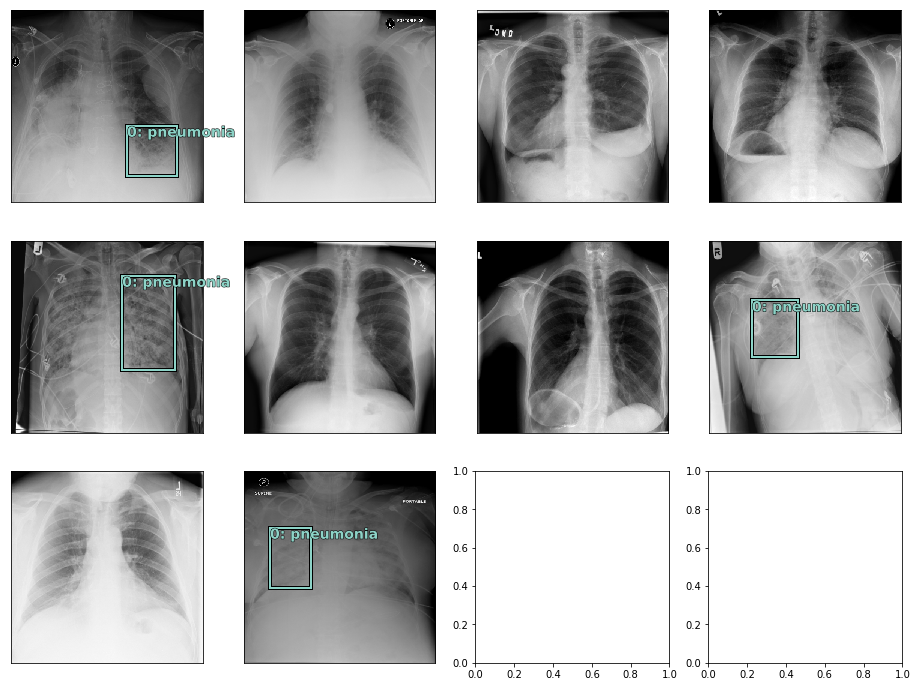

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    print(y[0][i])
    print(y[1][i])
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Set up model